In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [20]:
data = pd.read_csv("../data/00/merged/sentiment_stock_merged_AAPL.csv", parse_dates=["date_only", "date_only_stock"])
data = data.sort_values("date_only")


In [21]:
data["Tomorrow"] = data["Close"].shift(-1)
data["target"] = (data["Tomorrow"] > data["Close"]).astype(int)
data = data.drop("Tomorrow", axis=1)
print(data.head())

   date_only  posts_per_day  avg_sentiment  avg_sentiment_normalized  \
0 2024-09-09              4       0.021952                 51.097609   
1 2024-09-12              2      -0.242334                 37.883323   
2 2024-09-14              1       0.246950                 62.347500   
3 2024-09-16              1      -0.214463                 39.276875   
4 2024-09-18              3      -0.156211                 42.189454   

  date_only_stock ticker        Open        High         Low       Close  \
0      2024-09-10   AAPL  218.919998  221.479996  216.729996  220.110001   
1      2024-09-13   AAPL  223.580002  224.039993  221.910004  222.500000   
2             NaT    NaN         NaN         NaN         NaN         NaN   
3      2024-09-17   AAPL  215.750000  216.899994  214.500000  216.789993   
4      2024-09-19   AAPL  224.990005  229.820007  224.630005  228.869995   

       Volume  target  
0  51591000.0       1  
1  36766600.0       0  
2         NaN       0  
3  45519300.0 

In [22]:

data = data[['date_only', 'avg_sentiment', 'Close', 'date_only_stock', 'target']].dropna().reset_index(drop=True)
print(data.head())


   date_only  avg_sentiment       Close date_only_stock  target
0 2024-09-09       0.021952  220.110001      2024-09-10       1
1 2024-09-12      -0.242334  222.500000      2024-09-13       0
2 2024-09-16      -0.214463  216.789993      2024-09-17       1
3 2024-09-18      -0.156211  228.869995      2024-09-19       0
4 2024-09-19      -0.229400  228.199997      2024-09-20       0


In [23]:
scaler = MinMaxScaler()
data['avg_sentiment_scaled'] = scaler.fit_transform(data[['avg_sentiment']])

In [24]:
window_size = 5
X = []
y = []

for i in range(window_size, len(data) - 1):
    features = data[['avg_sentiment_scaled', 'target']].iloc[i - window_size:i].values  # Include both features
    X.append(features)
    y.append(int(data['Close'].iloc[i + 1] > data['Close'].iloc[i]))

X = np.array(X)
X = X.reshape(-1, window_size, 2)  # Reshape for LSTM with 2 features
y = np.array(y)

In [25]:
model = Sequential()
model.add(Input(shape=(window_size, 2)))  # Define input shape here
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [26]:
#data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
#print(data['target'].head)
#gave accuracy of Prediction Accuracy: 35.71%

In [27]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=False)  # 0.25 of 0.8 = 0.2
# Print the shape of X_train
print("Shape of X_train:", X_train.shape)

model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)  # X_train is consistent with input_shape

Shape of X_train: (37, 5, 2)
Epoch 1/20
3/3 [==============================] - 1s 3ms/step - loss: 0.6914 - accuracy: 0.5135
Epoch 2/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5135
Epoch 3/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5676
Epoch 4/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5676
Epoch 5/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5676
Epoch 6/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5676
Epoch 7/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.5676
Epoch 8/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5676
Epoch 9/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.5676
Epoch 10/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.5676
Epoch 11/2

1/1 [==============================] - 0s 152ms/step


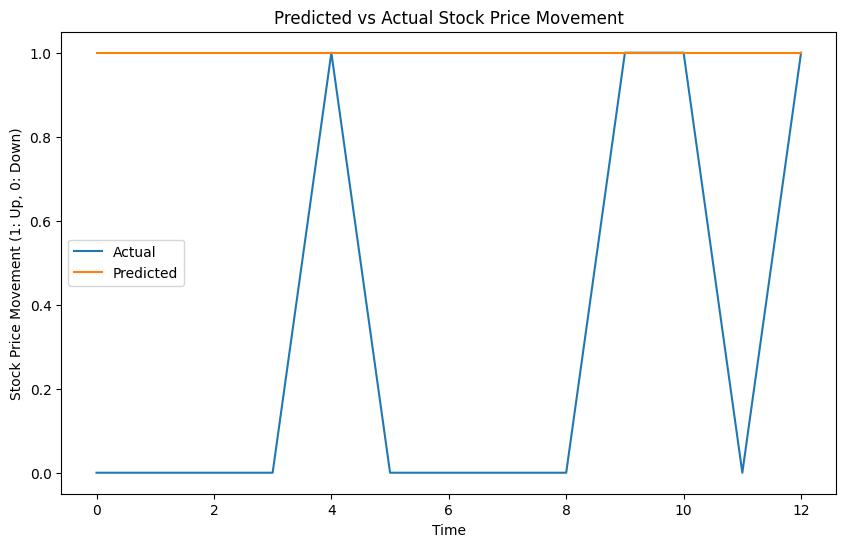

In [28]:
# prompt: generate a plot of predicted vs actual stock

import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price Movement (1: Up, 0: Down)')
plt.title('Predicted vs Actual Stock Price Movement')
plt.legend()
plt.show()


In [29]:
# prompt: print accuracy

y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")


1/1 [==============================] - 0s 10ms/step
Prediction Accuracy: 30.77%
